# Sales Forecasting - Optimized Model with Hyperparameter Tuning (Beta)

**Goal:** To improve upon the baseline model by using the Optuna library to find an optimal set of hyperparameters.

**Approach:** This notebook details the process of running a hyperparameter search on a sample of the data. The best parameters were then used to train a final, optimized model on the full dataset.

**Result:** The final optimized model, saved as `model_beta.txt`, achieved a validation RMSE of **18.93**, an improvement over the baseline model's score of 19.01.

## 1. Data Loading and Preparation

In [2]:
from sklearn.metrics import mean_squared_error
from datasets import load_dataset
import polars as pl
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns


/Users/dhruvpatel/opt/anaconda3/lib/python3.9/site-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [3]:

# Login using e.g. `huggingface-cli login` to access this dataset
ds = load_dataset("dunnowho/grocery-sales-forecasting")

In [4]:
print(ds)

DatasetDict({
    train: Dataset({
        features: ['id', 'date', 'store_nbr', 'item_nbr', 'unit_sales', 'onpromotion'],
        num_rows: 125497040
    })
    test: Dataset({
        features: ['id', 'date', 'store_nbr', 'item_nbr', 'unit_sales', 'onpromotion'],
        num_rows: 3370464
    })
})


In [5]:
ds['train'].to_pandas().head()

,id,date,store_nbr,item_nbr,unit_sales,onpromotion
0,0,2013-01-01,25,103665,7.0,NaN
1,1,2013-01-01,25,105574,1.0,NaN
2,2,2013-01-01,25,105575,2.0,NaN
3,3,2013-01-01,25,108079,1.0,NaN
4,4,2013-01-01,25,108701,1.0,NaN


In [6]:
ds['test'].to_pandas().head()

,id,date,store_nbr,item_nbr,unit_sales,onpromotion
0,125497040,2017-08-16,1,96995,NaN,0.0
1,125497041,2017-08-16,1,99197,NaN,0.0
2,125497042,2017-08-16,1,103501,NaN,0.0
3,125497043,2017-08-16,1,103520,NaN,0.0
4,125497044,2017-08-16,1,103665,NaN,0.0


In [7]:
# Convert the Hugging Face Dataset to Polars DataFrame
# This is a very fast and memory-efficient operation.
train_df = ds['train'].to_polars()
test_df = ds['test'].to_polars()

In [8]:
train_df.head()

id,date,store_nbr,item_nbr,unit_sales,onpromotion
i64,str,i64,i64,f64,f64
0,"""2013-01-01""",25,103665,7.0,null
1,"""2013-01-01""",25,105574,1.0,null
2,"""2013-01-01""",25,105575,2.0,null
3,"""2013-01-01""",25,108079,1.0,null
4,"""2013-01-01""",25,108701,1.0,null


In [9]:
train_df.shape

(125497040, 6)

In [10]:
print(train_df['item_nbr'].unique())

shape: (4_036,)
Series: 'item_nbr' [i64]
[
	96995
	99197
	103501
	103520
	103665
	…
	2123863
	2124052
	2126842
	2126944
	2127114
]


In [11]:
print(train_df['item_nbr'].unique().shape)

(4036,)


In [12]:
print(train_df['id'].unique().shape)

(125497040,)


In [13]:
test_df.tail()

id,date,store_nbr,item_nbr,unit_sales,onpromotion
i64,str,i64,i64,f64,f64
128867499,"""2017-08-31""",54,2132163,null,0.0
128867500,"""2017-08-31""",54,2132318,null,0.0
128867501,"""2017-08-31""",54,2132945,null,0.0
128867502,"""2017-08-31""",54,2132957,null,0.0
128867503,"""2017-08-31""",54,2134244,null,0.0


In [14]:
test_df.shape

(3370464, 6)

In [15]:
print(test_df['item_nbr'].unique().shape)

(3901,)


In [16]:
# Define the date where you want to split your training data
validation_start_date = "2017-08-01"

# Create the training and validation sets from your main train_df
X_train = train_df.filter(pl.col("date") < validation_start_date)
X_val = train_df.filter(pl.col("date") >= validation_start_date)

print(f"Training set shape: {X_train.shape}")
print(f"Validation set shape: {X_val.shape}")
print(f"Validation set shape: {test_df.shape}")

Training set shape: (123926072, 6)
Validation set shape: (1570968, 6)
Validation set shape: (3370464, 6)


## 2. Feature Engineering

In [17]:
# Rename for clarity before we create the final X/y sets
train_set = X_train
val_set = X_val

def feature_engineer(df):
    return df.with_columns([
        pl.col('date').str.to_date('%Y-%m-%d'),
        pl.col('onpromotion').fill_null(False).cast(pl.Boolean)
    ]).with_columns([
        pl.col('date').dt.year().alias('year'),
        pl.col('date').dt.month().alias('month'),
        pl.col('date').dt.weekday().alias('day_of_week'),
        pl.col('date').dt.week().alias('week_of_year')
    ])

# Apply the function to all data splits
train_set = feature_engineer(train_set)
val_set = feature_engineer(val_set)
test_df = feature_engineer(test_df)

print("Feature engineering complete.")
print("Training set columns:", train_set.columns)

Feature engineering complete.
Training set columns: ['id', 'date', 'store_nbr', 'item_nbr', 'unit_sales', 'onpromotion', 'year', 'month', 'day_of_week', 'week_of_year']


In [18]:
# Group by day of the week and sum sales
sales_by_day = (
    train_set.group_by("day_of_week")
    .agg(pl.sum("unit_sales"))
    .sort("day_of_week")
)

In [19]:
# Define feature columns and the target column
features = ['store_nbr', 'item_nbr', 'onpromotion', 'year', 'month', 'day_of_week', 'week_of_year']

In [34]:
import numpy as np

In [39]:
train_set_rnd = train_set.to_pandas().iloc[np.random.randint(0, 123926072, size=4000)]

In [21]:
min_train = train_set[:4000]

In [24]:
import seaborn as sns

In [42]:
train_set_rnd.head()

,id,date,store_nbr,item_nbr,unit_sales,onpromotion,year,month,day_of_week,week_of_year
123169974,123169974,2017-07-24,44,1240160,46.0,True,2017,7,1,30
98099761,98099761,2016-11-26,47,838415,3.0,True,2016,11,6,47
100504150,100504150,2016-12-20,3,209085,3.0,False,2016,12,2,51
24784250,24784250,2014-06-02,50,222879,48.0,False,2014,6,1,23
64821321,64821321,2015-12-13,53,1102975,1.0,False,2015,12,7,50


In [43]:
print(train_set_rnd["store_nbr"].unique())
print(train_set_rnd["date"].unique())

[44 47  3 50 53 31 46 37 24 48 49 17 39 38 12 54 10 13 34  9  5 45 43  8
 18  2  4  1  6  7 36 30 28 40 29 51 33 35 19 14 41 11 21 15 26 27 22 52
 42 20 23 16 32 25]
<DatetimeArray>
['2017-07-24 00:00:00', '2016-11-26 00:00:00', '2016-12-20 00:00:00',
 '2014-06-02 00:00:00', '2015-12-13 00:00:00', '2016-02-11 00:00:00',
 '2015-06-20 00:00:00', '2014-08-21 00:00:00', '2015-06-06 00:00:00',
 '2015-03-03 00:00:00',
 ...
 '2015-01-19 00:00:00', '2014-02-16 00:00:00', '2015-07-17 00:00:00',
 '2015-01-25 00:00:00', '2013-10-01 00:00:00', '2014-07-08 00:00:00',
 '2013-11-30 00:00:00', '2016-10-19 00:00:00', '2013-11-08 00:00:00',
 '2013-01-05 00:00:00']
Length: 1448, dtype: datetime64[ms]


In [45]:
plot = train_set_rnd.corr()

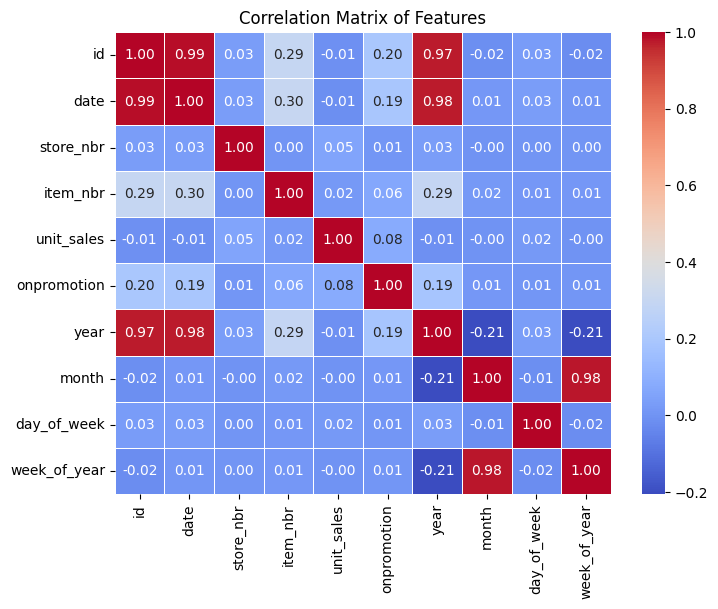

In [46]:
plt.figure(figsize=(8, 6))
# Adjust figure size for better readability
sns.heatmap(plot, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix of Features')
plt.show()

## 3. Exploratory Data Analysis (EDA)

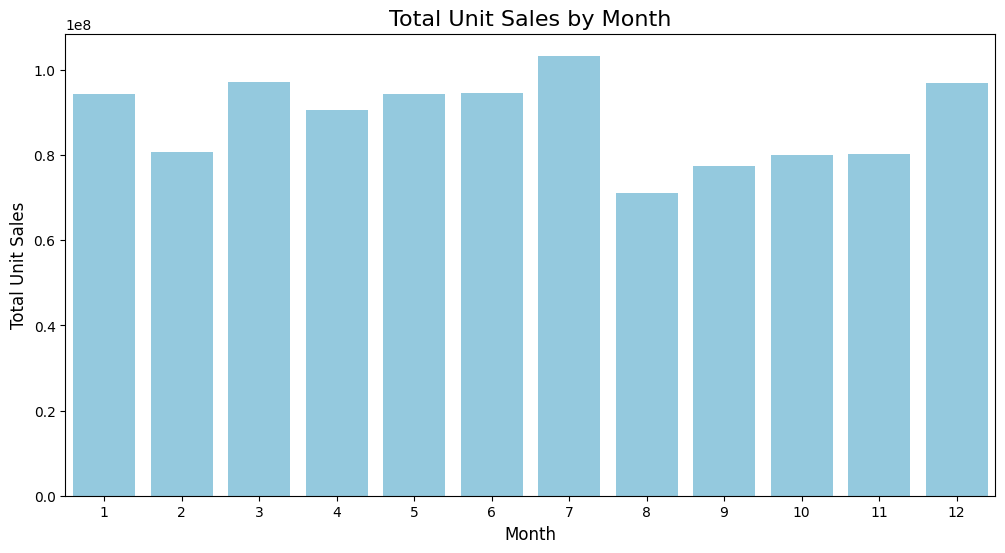

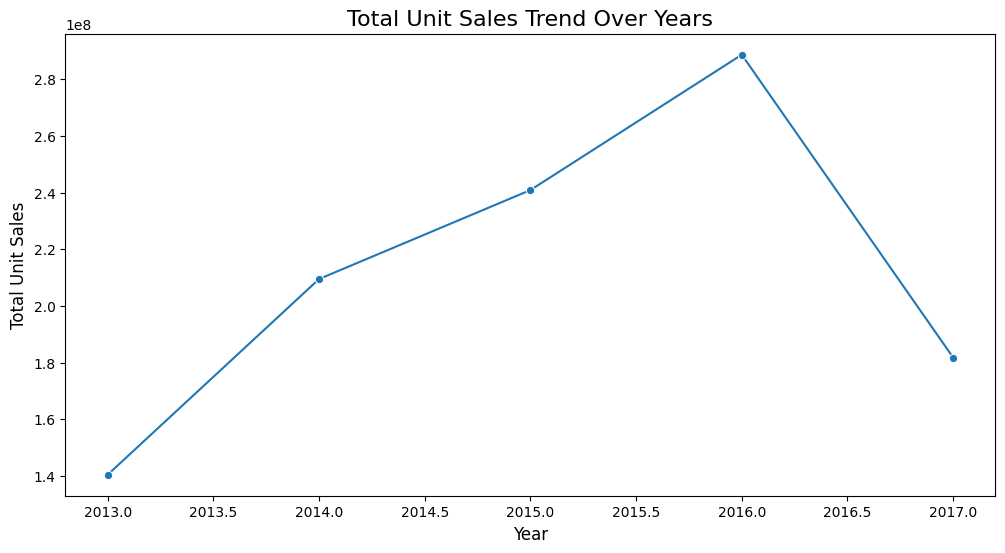

In [19]:
# --- EDA Plots ---

# a. Monthly Sales Trends
# This helps to see the seasonal pattern within a year
monthly_sales = (
    train_set.group_by("month")
    .agg(pl.sum("unit_sales"))
    .sort("month")
)

plt.figure(figsize=(12, 6))
sns.barplot(data=monthly_sales.to_pandas(), x="month", y="unit_sales", color="skyblue")
plt.title("Total Unit Sales by Month", fontsize=16)
plt.xlabel("Month", fontsize=12)
plt.ylabel("Total Unit Sales", fontsize=12)
plt.show()


# b. Yearly Sales Trends
# This shows the overall growth or decline over the years
yearly_sales = (
    train_set.group_by("year")
    .agg(pl.sum("unit_sales"))
    .sort("year")
)

plt.figure(figsize=(12, 6))
sns.lineplot(data=yearly_sales.to_pandas(), x="year", y="unit_sales", marker='o')
plt.title("Total Unit Sales Trend Over Years", fontsize=16)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Total Unit Sales", fontsize=12)
plt.show()

In [20]:
# Define feature columns and the target column
features = ['store_nbr', 'item_nbr', 'onpromotion', 'year', 'month', 'day_of_week', 'week_of_year']
target = 'unit_sales'
categorical_features = ['store_nbr', 'item_nbr', 'onpromotion']

# Create final training, validation, and test sets
X_train = train_set[features]
y_train = train_set[target]

X_val = val_set[features]
y_val = val_set[target]

X_test = test_df[features]

print("X/y splits created.")

X/y splits created.


In [21]:
# Create LightGBM datasets, keeping the raw data in memory for validation
train_data = lgb.Dataset(
    X_train.to_pandas(),
    label=y_train.to_pandas(),
    categorical_feature=categorical_features
    # free_raw_data=False  # <-- Add this line
)
val_data = lgb.Dataset(
    X_val.to_pandas(),
    label=y_val.to_pandas(),
    categorical_feature=categorical_features
    # free_raw_data=False  # <-- And add this line
)

## 4. Hyperparameter Tuning with Optuna

To find the best model settings, we run a hyperparameter search using Optuna on a smaller sample of the data to avoid memory issues and reduce runtime.

In [22]:
import gc

# --- Create AGGRESSIVE Samples for Tuning to Save Memory ---

# Reduce the training sample size
print("Creating a smaller sample of the training data for tuning...")
train_set_sample = train_set.sample(n=500_000, seed=42) # Reduced to 500k
X_train_sample = train_set_sample[features]
y_train_sample = train_set_sample[target]
train_data_sample = lgb.Dataset(X_train_sample.to_pandas(), label=y_train_sample.to_pandas(), categorical_feature=categorical_features)

# ALSO reduce the validation set size for tuning
print("Creating a smaller sample of the validation data for tuning...")
val_set_sample = val_set.sample(n=250_000, seed=42) # Sampled validation set
X_val_sample = val_set_sample[features]
y_val_sample = val_set_sample[target]
val_data_sample = lgb.Dataset(X_val_sample.to_pandas(), label=y_val_sample.to_pandas(), categorical_feature=categorical_features)

# --- Clean Up Large Unused DataFrames ---
# We no longer need these massive dataframes for the tuning step
del train_df
del train_set
gc.collect() # Manually trigger garbage collection

print("Sampled datasets created and memory cleared for tuning.")

Creating a smaller sample of the training data for tuning...
Creating a smaller sample of the validation data for tuning...
Sampled datasets created and memory cleared for tuning.


In [23]:
import optuna

# This cell requires your prepared data: train_data and val_data

def objective(trial):
    # Define the search space for the hyperparameters
    params = {
        'objective': 'regression_l1',
        'metric': 'rmse',
        'n_estimators': 1000,
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'num_leaves': trial.suggest_int('num_leaves', 20, 64),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.6, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.6, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0, log=True),
        'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0, log=True),
        'verbose': -1,
        'n_jobs': -1,
        'seed': 42
    }

    # Train the model with the suggested parameters
    model = lgb.train(
        params,
        # train_data,
        train_data_sample,
        valid_sets=[val_data],
        callbacks=[lgb.early_stopping(50, verbose=False)]
    )

    # Return the validation score for Optuna to minimize
    rmse = model.best_score['valid_0']['rmse']
    return rmse


In [24]:
print("Starting hyperparameter tuning with Optuna...")
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=20)

# --- Print the Best Results ---
print("\nTuning complete!")
print("Best trial:")
best_trial = study.best_trial

print(f"  Best RMSE: {best_trial.value}")
print("  Best Params: ")
for key, value in best_trial.params.items():
    print(f"    '{key}': {value},")

[I 2025-08-04 11:01:01,584] A new study created in memory with name: no-name-dcb52408-4615-4a6b-be96-31a799bf73f9


Starting hyperparameter tuning with Optuna...
[LightGBM] [Warning] Met categorical feature which contains sparse values. Consider renumbering to consecutive integers started from zero


[I 2025-08-04 11:02:15,513] Trial 0 finished with value: 19.88741149635231 and parameters: {'learning_rate': 0.09444441854415231, 'num_leaves': 52, 'feature_fraction': 0.672510674066292, 'bagging_fraction': 0.9353781853825962, 'bagging_freq': 1, 'lambda_l1': 1.8288089546931222e-08, 'lambda_l2': 1.524113504330669e-06}. Best is trial 0 with value: 19.88741149635231.
[I 2025-08-04 11:04:01,989] Trial 1 finished with value: 19.94218303617569 and parameters: {'learning_rate': 0.017910706498225806, 'num_leaves': 59, 'feature_fraction': 0.6696488038716107, 'bagging_fraction': 0.9688012784092039, 'bagging_freq': 1, 'lambda_l1': 6.300864988938508e-06, 'lambda_l2': 1.3387145627471746e-06}. Best is trial 0 with value: 19.88741149635231.
[I 2025-08-04 11:05:27,562] Trial 2 finished with value: 20.258133633096595 and parameters: {'learning_rate': 0.07296215530832188, 'num_leaves': 45, 'feature_fraction': 0.8154307361763987, 'bagging_fraction': 0.6404372194389351, 'bagging_freq': 1, 'lambda_l1': 3.8


Tuning complete!
Best trial:
  Best RMSE: 19.71049655623131
  Best Params: 
    'learning_rate': 0.09878326105837643,
    'num_leaves': 64,
    'feature_fraction': 0.7243367776415582,
    'bagging_fraction': 0.9976900862501248,
    'bagging_freq': 4,
    'lambda_l1': 1.096856292461131e-08,
    'lambda_l2': 0.00045577687590988734,


<!-- Tuning complete!
Best trial:
  Best RMSE: 19.71049655623131
  Best Params: 
    'learning_rate': 0.09878326105837643,
    'num_leaves': 64,
    'feature_fraction': 0.7243367776415582,
    'bagging_fraction': 0.9976900862501248,
    'bagging_freq': 4,
    'lambda_l1': 1.096856292461131e-08,
    'lambda_l2': 0.00045577687590988734, -->

Tuning complete!
Best trial:
  Best RMSE: 19.71049655623131
  Best Params: 
    'learning_rate': 0.09878326105837643,
    'num_leaves': 64,
    'feature_fraction': 0.7243367776415582,
    'bagging_fraction': 0.9976900862501248,
    'bagging_freq': 4,
    'lambda_l1': 1.096856292461131e-08,
    'lambda_l2': 0.00045577687590988734,

## 5. Training the Final Optimized Model

Using the best parameters found by Optuna, we now train the final model on the full training dataset.

In [22]:
# This cell uses X_train, y_train, train_data, and val_data

# 1. Update these parameters with the "Best Params" from your Optuna results
params = {
    'objective': 'regression_l1',
    'metric': 'rmse',
    'n_estimators': 1500, # Increased for the final training run
    'seed': 42,
    'n_jobs': 4,
    'verbose': -1,
    
    # --- PASTE OPTUNA'S BEST PARAMS BELOW ---
    'learning_rate': 0.09878326105837643,  # Example value
    'num_leaves': 40,      # Example value
    'feature_fraction': 0.7243367776415582, # Example value
    'bagging_fraction': 0.9976900862501248, # Example value
    'bagging_freq': 4,      # Example value
    'lambda_l1': 1.096856292461131e-08,       # Example value
    'lambda_l2': 0.00045577687590988734,       # Example value
}

In [23]:
# 2. Dynamically add the best parameters found by Optuna
# The .update() method will add/overwrite keys with the optimized values
params.update(study.best_trial.params)

print("--- Final Parameters for Training ---")
print(params)
print("------------------------------------")

NameError: name 'study' is not defined

In [23]:
# 2. Train the final model
print("Training final optimized model...")
final_model = lgb.train(
    params,
    train_data,
    valid_sets=[train_data, val_data],
    callbacks=[lgb.early_stopping(100, verbose=True)]
)
print("Final model training complete.")

Training final optimized model...
[LightGBM] [Warning] Met categorical feature which contains sparse values. Consider renumbering to consecutive integers started from zero
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	training's rmse: 19.7594	valid_1's rmse: 18.9303
Final model training complete.


In [24]:
# 3. Save the final model to a file
final_model.save_model('model_beta.txt')
print("Final optimized model saved successfully to 'final_model.txt'!")

Final optimized model saved successfully to 'final_model.txt'!


# Save the model to a file
model.save_model('model_beta.txt')

print("Model saved successfully!")

In [25]:
# Load the model from the file
model = lgb.Booster(model_file='model_beta.txt')

print("Model loaded successfully!")

Model loaded successfully!


## 6. Model Evaluation and Visualization

In [26]:
# Make predictions on the validation set
val_predictions = model.predict(X_val.to_pandas(), num_iteration=model.best_iteration)

# Calculate the Root Mean Squared Error (RMSE)
rmse = mean_squared_error(y_val.to_pandas(), val_predictions, squared=False)
print(f"Validation RMSE: {rmse}")

Validation RMSE: 18.930324900127232


In [27]:
# Make predictions on the final test set
test_predictions = model.predict(X_test.to_pandas(), num_iteration=model.best_iteration)

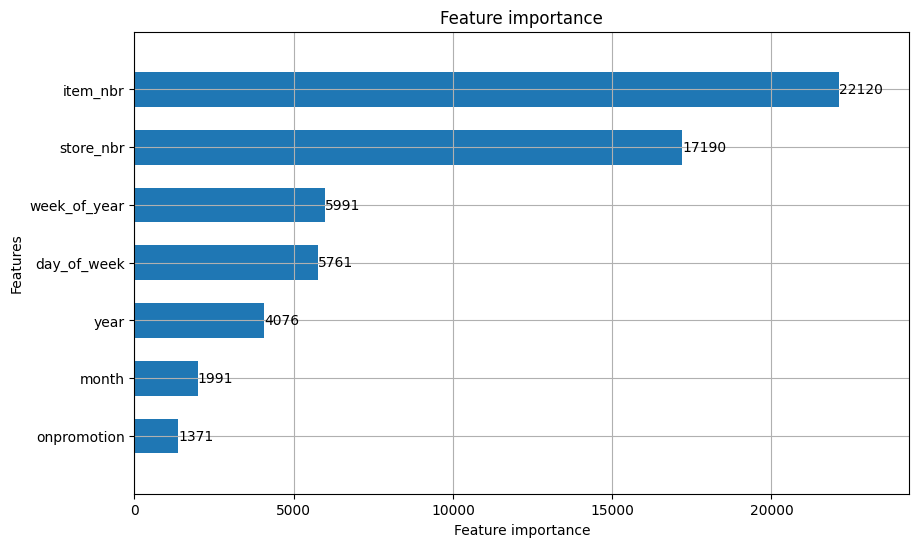

In [28]:

lgb.plot_importance(model, height=0.6, figsize=(10, 6))
plt.show()

In [30]:
# Add predictions to the validation set dataframe
val_set_with_preds = val_set.with_columns(
    pl.Series(name="predicted_sales", values=val_predictions)
)

# Choose a specific store and item to visualize
# Let's pick an item from a store that has consistent sales
store_to_plot = 44
item_to_plot = 105574 # A common grocery item

# Filter for that specific time series
single_item_df = val_set_with_preds.filter(
    (pl.col("store_nbr") == store_to_plot) & (pl.col("item_nbr") == item_to_plot)
)

# Convert to pandas for easy plotting
single_item_df_pd = single_item_df.to_pandas()

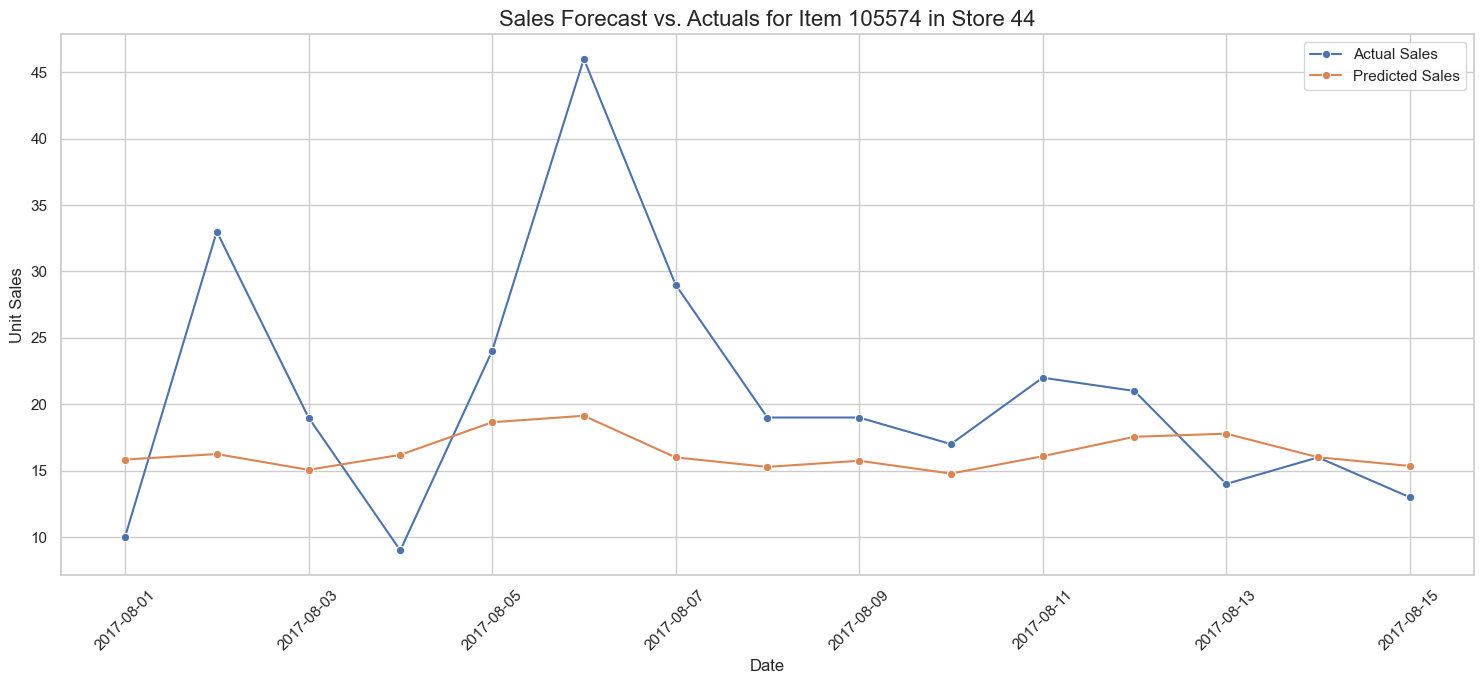

In [31]:

# Set plot style and size
sns.set(style='whitegrid')
plt.figure(figsize=(15, 7))

# Plot actual vs. predicted sales
sns.lineplot(data=single_item_df_pd, x='date', y='unit_sales', label='Actual Sales', marker='o')
sns.lineplot(data=single_item_df_pd, x='date', y='predicted_sales', label='Predicted Sales', marker='o')

# Add titles and labels
plt.title(f'Sales Forecast vs. Actuals for Item {item_to_plot} in Store {store_to_plot}', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Unit Sales', fontsize=12)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()

In [33]:
# --- Create a Detailed Prediction File ---

# Add the predictions as a new column to the original test_df
# This keeps all the original feature information
predictions_with_features = test_df.with_columns(
    pl.Series(name="predicted_sales", values=test_predictions)
)

# Clip at 0, since we can't have negative sales
predictions_with_features = predictions_with_features.with_columns(
    pl.when(pl.col("predicted_sales") < 0)
    .then(0)
    .otherwise(pl.col("predicted_sales"))
    .alias("predicted_sales")
)

# Select the columns you want in your final CSV
# This includes the id, original features, and your new prediction
final_predictions_df = predictions_with_features[
    ['id', 'date', 'store_nbr', 'item_nbr', 'onpromotion', 'predicted_sales']
]

# Save the detailed submission file
final_predictions_df.write_csv("detailed_predictions_beta.csv")

print("Detailed prediction file 'detailed_predictions_beta.csv' created successfully!")
print("Prediction file head:")
print(final_predictions_df.head())

Detailed prediction file 'detailed_predictions_beta.csv' created successfully!
Prediction file head:
shape: (5, 6)
┌───────────┬────────────┬───────────┬──────────┬─────────────┬─────────────────┐
│ id        ┆ date       ┆ store_nbr ┆ item_nbr ┆ onpromotion ┆ predicted_sales │
│ ---       ┆ ---        ┆ ---       ┆ ---      ┆ ---         ┆ ---             │
│ i64       ┆ date       ┆ i64       ┆ i64      ┆ bool        ┆ f64             │
╞═══════════╪════════════╪═══════════╪══════════╪═════════════╪═════════════════╡
│ 125497040 ┆ 2017-08-16 ┆ 1         ┆ 96995    ┆ false       ┆ 1.526996        │
│ 125497041 ┆ 2017-08-16 ┆ 1         ┆ 99197    ┆ false       ┆ 1.758065        │
│ 125497042 ┆ 2017-08-16 ┆ 1         ┆ 103501   ┆ false       ┆ 4.413731        │
│ 125497043 ┆ 2017-08-16 ┆ 1         ┆ 103520   ┆ false       ┆ 1.832791        │
│ 125497044 ┆ 2017-08-16 ┆ 1         ┆ 103665   ┆ false       ┆ 2.577739        │
└───────────┴────────────┴───────────┴──────────┴─────────────┴──

## 7. Final Conclusion

The hyperparameter tuning was successful, resulting in a model with a validation RMSE of **18.93**. This is a noticeable improvement over the baseline model's score of 19.01.

The final, optimized model (`model_beta.txt`) and its associated predictions (`detailed_predictions_beta.csv`) are now ready for use in the interactive Streamlit application.